# Simple GAN from the lecures to function as a starting point.
Tutorial from https://salu133445.github.io/ismir2019tutorial/


## Prerequisites

In [1]:
# Install packages
!pip3 install torch torchvision matplotlib tqdm livelossplot termcolor scikit-image

In [2]:
# Import packages
from IPython.display import clear_output
from ipywidgets import interact, IntSlider
import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from livelossplot import PlotLosses
from tqdm import tqdm
from termcolor import colored
import pandas as pd
import os
import ast
from skimage import io, transform
from torchvision import transforms, utils



/home/mm/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


## Settings

In [3]:
# Hyperparameters
batch_size = 64
latent_dim = 25*64
feature_dim = 120 * 90 * 3
n_steps = 10000

# Sampler settings
sample_interval = 100
n_cols = 10
n_rows = 2
n_samples = 20
assert n_samples == n_cols * n_rows, (
    "Number of samples and number of images per column/row do not match.")


## Training data loader function

In [4]:
class YThumbnailDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        def from_np_array(array_string):
    
            return np.array(ast.literal_eval(array_string))
        
        self.thumbnail_frame = pd.read_csv(csv_file, converters={'VECTOR': from_np_array})
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.thumbnail_frame)
    
    

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.thumbnail_frame.iloc[idx, 0])
        image = io.imread(img_name)
        vector = self.thumbnail_frame.iloc[idx, 5].flatten()

        vector = np.pad(vector, (0, 25*64 - vector.size), mode='constant', constant_values=0)
        sample = {'image': image, 'vector': vector}

        if self.transform:
            sample = self.transform(sample)

        return sample


In [5]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, vector = sample['image'], sample['vector']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))


        return {'image': img, 'vector': vector}
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, vector = sample['image'], sample['vector']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'vector': torch.from_numpy(vector)}

In [6]:
TrainingSet = YThumbnailDataset('../data-aquisition/VectorizedFiles/subFrame14.csv', '../data-aquisition/ImagesLarge/subFrame14', transform=transforms.Compose([Rescale((90,120)),ToTensor(),]))

In [7]:
TrainingSet[34]['image'].shape

torch.Size([3, 90, 120])

## Utility functions

In [8]:
def images_to_vectors(images):
    """Convert images to vectors."""
    return images.view(images.size(0), 90*120*3)

def vectors_to_images(vectors):
    """Convert vectors to images."""
    return vectors.view(vectors.size(0), 3, 90, 120)

## Neural networks

In [9]:
class Generator(torch.nn.Module):
    """A multilayer perceptron (MLP) based generator. The generator takes as
    input a latent vector and outputs a fake sample."""
    def __init__(self):
        super().__init__()
        self.hidden0 = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 256),
            torch.nn.LeakyReLU())
        self.hidden1 = torch.nn.Sequential(
            torch.nn.Linear(256, 512),
            torch.nn.LeakyReLU())
        self.hidden2 = torch.nn.Sequential(
            torch.nn.Linear(512, 1024),
            torch.nn.LeakyReLU())
        self.out = torch.nn.Sequential(
            torch.nn.Linear(1024, feature_dim),
            torch.nn.Sigmoid())

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [10]:
class Discriminator(torch.nn.Module):
    """A multilayer perceptron (MLP) based discriminator. The discriminator
    takes as input either a real sample (in the training data) or a fake sample
    (generated by the generator) and outputs a scalar indicating its authentity.
    """
    def __init__(self):
        super().__init__()
        self.hidden0 = torch.nn.Sequential( 
            torch.nn.Linear(feature_dim, 1024),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout())
        self.hidden1 = torch.nn.Sequential(
            torch.nn.Linear(1024, 512),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout())
        self.hidden2 = torch.nn.Sequential(
            torch.nn.Linear(512, 256),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout())
        self.out = torch.nn.Sequential(
            torch.nn.Linear(256, 1))

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

## Training function

In [11]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples):
    """Compute the gradient penalty for regularization. Intuitively, the
    gradient penalty help stablize the magnitude of the gradients that the
    discriminator provides to the generator, and thus help stablize the training
    of the generator."""
    # Get random interpolations between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1).cuda()
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples))
    interpolates = interpolates.requires_grad_(True)
    # Get the discriminator output for the interpolations
    d_interpolates = discriminator(interpolates)
    # Get gradients w.r.t. the interpolations
    fake = torch.ones(real_samples.shape[0], 1).cuda()
    gradients = torch.autograd.grad(outputs=d_interpolates, inputs=interpolates,
                                    grad_outputs=fake, create_graph=True,
                                    retain_graph=True, only_inputs=True)[0]
    # Compute gradient penalty
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [12]:
def train_one_step(d_optimizer, g_optimizer, real_samples):
    """Train the networks for one step."""
    # Sample from the lantent distribution
    
    real_samples = real_samples.float()

    latent = torch.randn(batch_size, latent_dim)
    
    # Transfer data to GPU
    if torch.cuda.is_available():
        real_samples = real_samples.cuda()
        

        latent = latent.cuda()
    
    # === Train the discriminator ===
    # Reset cached gradients to zero
    discriminator.zero_grad()
    # Get discriminator outputs for the real samples
    prediction_real = discriminator(real_samples)
    # Compute the loss function
    d_loss_real = torch.mean(torch.nn.functional.relu(1. - prediction_real))
    # Backpropagate the gradients
    d_loss_real.backward()
    
    # Generate fake samples with the generator
    fake_samples = generator(latent)
    # Get discriminator outputs for the fake samples
    prediction_fake_d = discriminator(fake_samples.detach())
    # Compute the loss function
    d_loss_fake = torch.mean(torch.nn.functional.relu(1. + prediction_fake_d))
    # Backpropagate the gradients
    d_loss_fake.backward()

    # Compute gradient penalty
    gradient_penalty = 10.0 * compute_gradient_penalty(
        discriminator, real_samples.data, fake_samples.data)
    # Backpropagate the gradients
    gradient_penalty.backward()

    # Update the weights
    d_optimizer.step()
    
    # === Train the generator ===
    # Reset cached gradients to zero
    generator.zero_grad()
    # Get discriminator outputs for the fake samples
    prediction_fake_g = discriminator(fake_samples)
    # Compute the loss function
    g_loss = -torch.mean(prediction_fake_g)
    # Backpropagate the gradients
    g_loss.backward()
    # Update the weights
    g_optimizer.step()

    return d_loss_real + d_loss_fake, g_loss

## Training preparation

In [13]:
# Create data loader
data_loader = DataLoader(TrainingSet, batch_size=batch_size,
                        shuffle=True, num_workers=0, drop_last=True,)


# Create neural networks
discriminator = Discriminator()
generator = Generator()

# Create optimizers
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001, 
                                betas=(0.0, 0.9))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001,
                                betas=(0.0, 0.9))

# Prepare the inputs for the sampler, which will run during the training
sample_latent = torch.randn(n_samples, latent_dim)

# Transfer the neural nets and samples to GPU
if torch.cuda.is_available():
    discriminator = discriminator.cuda()
    generator = generator.cuda()
    sample_latent = sample_latent.cuda()

# Create an empty dictionary to sotre history samples
history_samples = {}

# Create a LiveLoss logger instance for monitoring
groups = {'discriminator': ['d_loss'], 'generator': ['g_loss']}
plotlosses = PlotLosses(groups=groups)

# Initialize step
step = 0

## Training iterations

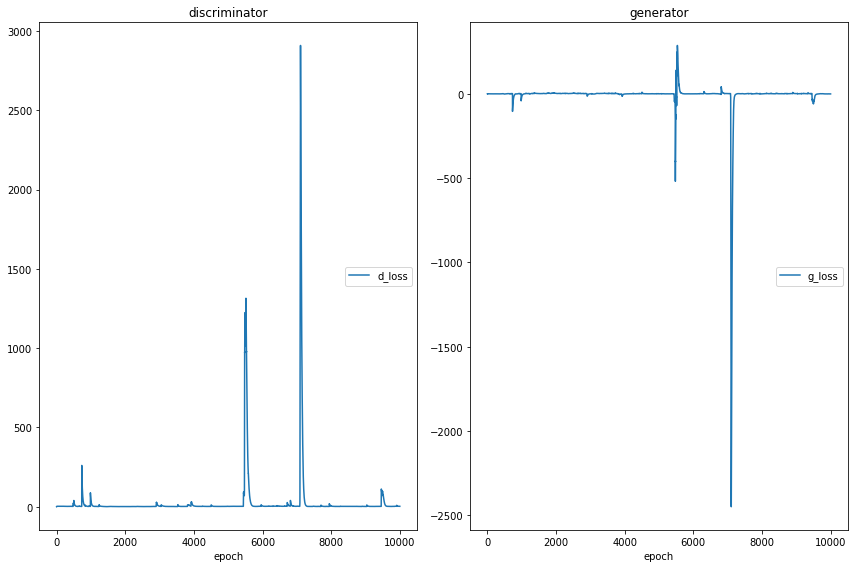

discriminator
	d_loss           	 (min:    0.000, max: 2909.536, cur:    2.699)
generator
	g_loss           	 (min: -2449.210, max:  287.166, cur:   -0.301)


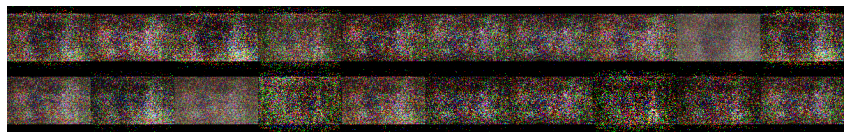

(d_loss= 3.041524, g_loss=-2.331258): 10001it [55:43,  2.40it/s]                

In [14]:


# Create a progress bar instance for monitoring
if step < n_steps + 1:
    progress_bar = tqdm(total=n_steps, initial=step, ncols=80, mininterval=1)
else:
    print(colored('[Warnings]', 'red'), 'Current step exceeds total step.')

# Start iterations
while step < n_steps + 1:
    # Iterate over the dataset
    for batch_index, real_batch in enumerate(data_loader):
        # Convert input images into vectors

        real_samples = images_to_vectors(real_batch['image'])


        # Train the neural networks
        d_loss, g_loss = train_one_step(d_optimizer, g_optimizer, real_samples)

        # Record smoothened loss values to LiveLoss logger
        if step > 0:
            running_d_loss = 0.05 * d_loss + 0.95 * running_d_loss
            running_g_loss = 0.05 * g_loss + 0.95 * running_g_loss
        else:
            running_d_loss, running_g_loss = 0.0, 0.0
        plotlosses.update({'d_loss': running_d_loss,
                         'g_loss': running_g_loss})


        # Update losses to progress bar
        progress_bar.set_description_str(
            "(d_loss={: 8.6f}, g_loss={: 8.6f})".format(d_loss, g_loss))
        
        if step % sample_interval == 0:
            # Get generated samples
            samples = vectors_to_images(generator(sample_latent))
            print(samples.shape)
            samples = samples.cpu().detach().numpy() \
                             .reshape(n_rows, n_cols, 3, 90, 120) \
                             .transpose((0, 3, 1, 4, 2)) \
                             .reshape(n_rows * 90, n_cols * 120, 3)
            history_samples[step] = samples

            # Display loss curves
            clear_output(True)
            if step > 0:
                plotlosses.send()
            
            # Display generated samples
            plt.figure(figsize=(15, 3))
            plt.imshow(samples, cmap='Greys', vmin=0, vmax=1)
            plt.axis('off')
            plt.show()

        step += 1
        progress_bar.update(1)
        if step >= n_steps:
            break

In [15]:
# Show history
slider = IntSlider(min=0, max=n_steps, value=n_steps, step=sample_interval,
                   layout={'width': '500px'})
@interact
def plot(step=slider):
    plt.figure(figsize=(15, 3))
    plt.imshow(history_samples[step], cmap='Greys', vmin=0, vmax=1)
    plt.axis('off')
    plt.show()

interactive(children=(IntSlider(value=10000, description='step', layout=Layout(width='500px'), max=10000, step…